In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from os import makedirs
from os.path import join, exists
from nilearn.plotting import plot_connectome, plot_roi, find_parcellation_cut_coords
import bct
import datetime
from nilearn.mass_univariate import permuted_ols
from scipy.stats import pearsonr, spearmanr

sns.set(context='poster', style='ticks')

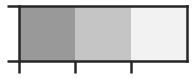

In [2]:
crayons_l = sns.crayon_palette(['Vivid Tangerine', 'Cornflower'])
crayons_d = sns.crayon_palette(['Brick Red', 'Midnight Blue'])
grays = sns.light_palette('#999999', n_colors=3, reverse=True)

f_2 = sns.crayon_palette(['Red Orange', 'Vivid Tangerine'])
m_2 = sns.crayon_palette(['Cornflower', 'Cerulean'])

In [3]:
def jili_sidak_mc(data, alpha):
    import math
    import numpy as np

    mc_corrmat = data.corr()
    mc_corrmat.fillna(0, inplace=True)
    eigvals, eigvecs = np.linalg.eig(mc_corrmat)

    M_eff = 0
    for eigval in eigvals:
        if abs(eigval) >= 0:
            if abs(eigval) >= 1:
                M_eff += 1
            else:
                M_eff += abs(eigval) - math.floor(abs(eigval))
        else:
            M_eff += 0
    print('Number of effective comparisons: {0}'.format(M_eff))

    #and now applying M_eff to the Sidak procedure
    sidak_p = 1 - (1 - alpha)**(1/M_eff)
    if sidak_p < 0.00001:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:2e} after corrections'.format(sidak_p))
    else:
        print('Critical value of {:.3f}'.format(alpha),'becomes {:.6f} after corrections'.format(sidak_p))
    return sidak_p, M_eff

In [4]:
subjects = ['101', '102', '103', '104', '106', '107', '108', '110', '212', '213',
            '214', '215', '216', '217', '218', '219', '320', '321', '322', '323',
            '324', '325', '327', '328', '329', '330', '331', '332', '333', '334',
            '335', '336', '337', '338', '339', '340', '341', '342', '343', '344',
            '345', '346', '347', '348', '349', '350', '451', '452', '453', '455',
            '456', '457', '458', '459', '460', '462', '463', '464', '465', '467',
            '468', '469', '470', '502', '503', '571', '572', '573', '574', '575',
            '577', '578', '579', '580', '581', '582', '584', '585', '586', '587',
            '588', '589', '590', '591', '592', '593', '594', '595', '596', '597',
            '598', '604', '605', '606', '607', '608', '609', '610', '611', '612',
            '613', '614', '615', '616', '617', '618', '619', '620', '621', '622',
            '623', '624', '625', '626', '627', '628', '629', '630', '631', '633',
            '634']
#subjects = ['101', '102']

sink_dir = '/Users/katherine/Dropbox/Projects/physics-retrieval/data/output'
fig_dir = '/Users/katherine/Dropbox/Projects/physics-retrieval/figures/'

shen = '/Users/katherine/Dropbox/Projects/physics-retrieval/shen2015_2mm_268_parcellation.nii.gz'
craddock = '/Users/katherine/Dropbox/Projects/physics-retrieval/craddock2012_tcorr05_2level_270_2mm.nii.gz'
masks = ['shen2015', 'craddock2012']

tasks = {'retr': [{'conditions': ['Physics', 'General']},
                  {'runs': [0,1]}], 
         'fci': [{'conditions': ['Physics', 'NonPhysics']},
                  {'runs': [0,1,2]}]}

sessions = [0,1]
sesh = ['pre', 'post']
conds = ['high-level', 'lower-level']

index = pd.MultiIndex.from_product([subjects, sessions, tasks, conds, masks], 
                                   names=['subject', 'session', 'task', 'condition', 'mask'])

In [6]:
data_dir = '/Users/katherine/Dropbox/Projects/physics-retrieval/data'
b_df = pd.read_csv(join(data_dir, 'rescored', 'non-brain-data.csv'), index_col=0, header=0)


In [7]:
head_size = pd.read_csv(join(data_dir, 'head-size_2019-05-29 15:19:53.287525.csv'), index_col=0, header=0)
head_size['normalized head size'] = (head_size['average_head_size']-np.mean(head_size['average_head_size']))/np.std(head_size['average_head_size'])

In [8]:
fd = pd.read_csv(join(data_dir,'avg-fd-per-condition-per-run_2019-05-29.csv'), index_col=0, header=0)
fd['normalized fd'] = (fd['average fd']-np.mean(fd['average fd']))/np.std(fd['average fd'])
retr_fd = fd[fd['task'] == 'retr']
fci_fd = fd[fd['task'] == 'fci']

df_pivot = retr_fd[retr_fd['condition'] == 'high-level'].reset_index()
retr_phys_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
retr_phys_fd.rename({'pre': 'pre phys retr fd', 'post': 'post phys retr fd'}, axis=1, inplace=True)

df_pivot = retr_fd[retr_fd['condition'] == 'lower-level'].reset_index()
retr_genr_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
retr_genr_fd.rename({'pre': 'pre gen retr fd', 'post': 'post gen retr fd'}, axis=1, inplace=True)

df_pivot = fci_fd[fci_fd['condition'] == 'high-level'].reset_index()
fci_phys_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
fci_phys_fd.rename({'pre': 'pre phys fci fd', 'post': 'post phys fci fd'}, axis=1, inplace=True)

df_pivot = fci_fd[fci_fd['condition'] == 'lower-level'].reset_index()
fci_ctrl_fd = df_pivot.pivot(index='subject', columns='session', values='average fd')
fci_ctrl_fd.rename({'pre': 'pre ctrl fci fd', 'post': 'post ctrl fci fd'}, axis=1, inplace=True)

In [9]:
rest_fd = pd.read_csv(join(data_dir, 'avg-fd-per-run-rest_2019-05-31.csv'), index_col=0, header=0)
rest_fd['normalized fd'] = (rest_fd['average fd']-np.mean(rest_fd['average fd']))/np.std(rest_fd['average fd'])

df_pivot = rest_fd.reset_index()
rest_fd = df_pivot.pivot(index='subject', columns='session', values='normalized fd')
rest_fd.rename({'pre': 'pre rest fd', 'post': 'post rest fd'}, axis=1, inplace=True)

In [10]:
iqs = ['VCI', 'WMI', 'PRI', 'PSI', 'FSIQ']

In [11]:
big_df = pd.concat([b_df, retr_phys_fd, retr_genr_fd, fci_phys_fd, fci_ctrl_fd, rest_fd], axis=1)

## First, we'll test connectivity during the physics knowledge task
We'll run the permuted OLS regressions with few permutations for a first pass look at how brain connectivity explains variance in different subscores of the WAIS. Significant regressions at this step will be re-run later with more permutations, for more accurate <i>p</i>- and <i>t</i>-values. This is a more efficient use of computational resources than running all possible regressions with many permutations right off the bat.

In [5]:
#read in every person's connectivity matrix (yikes)
#one task & condition at a time, I think. otherwise it becomes a memory issue
post_retr_conn = pd.DataFrame(columns=np.arange(0,268**2))

for subject in subjects:
    try:
        corrmat = np.genfromtxt(join(sink_dir, '{0}-session-1_retr-Physics_shen2015-corrmat.csv'.format(subject)),
                                delimiter=' ')
        post_retr_conn.at[subject] = np.ravel(corrmat, order='F')
    except Exception as e:
        print(subject, e)
avg_corrmat = np.mean(post_retr_conn.values, axis=1).reshape((268,268), order='F')
avg_corrmat_df = pd.DataFrame(avg_corrmat, index=np.arange(1,269), columns=np.arange(1,269))

213 /Users/katherine/Dropbox/Projects/physics-retrieval/data/output/213-session-1_retr-Physics_shen2015-corrmat.csv not found.
217 /Users/katherine/Dropbox/Projects/physics-retrieval/data/output/217-session-1_retr-Physics_shen2015-corrmat.csv not found.
322 /Users/katherine/Dropbox/Projects/physics-retrieval/data/output/322-session-1_retr-Physics_shen2015-corrmat.csv not found.
329 /Users/katherine/Dropbox/Projects/physics-retrieval/data/output/329-session-1_retr-Physics_shen2015-corrmat.csv not found.
332 /Users/katherine/Dropbox/Projects/physics-retrieval/data/output/332-session-1_retr-Physics_shen2015-corrmat.csv not found.
452 /Users/katherine/Dropbox/Projects/physics-retrieval/data/output/452-session-1_retr-Physics_shen2015-corrmat.csv not found.
456 /Users/katherine/Dropbox/Projects/physics-retrieval/data/output/456-session-1_retr-Physics_shen2015-corrmat.csv not found.
457 /Users/katherine/Dropbox/Projects/physics-retrieval/data/output/457-session-1_retr-Physics_shen2015-corrmat

In [12]:
for column in post_retr_conn.columns:
    num = np.nonzero(post_retr_conn[column].values)[0].shape
    if num[0] <=  5:
        post_retr_conn.drop(column, axis=1, inplace=True)

In [13]:
big_df.index= big_df.index.astype(int)
post_retr_conn.index = post_retr_conn.index.astype(int)
post_retr_conn = post_retr_conn.astype('float')

all_data = pd.concat([big_df, post_retr_conn], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)
conns = list(set(post_retr_conn.columns))


In [15]:
sig = {}

for iq in iqs: 
    p, t, _ = permuted_ols(all_data['{0}2'.format(iq)].values, 
                           all_data[conns].values, 
                           all_data[['{0}2XSex'.format(iq), 
                                     '{0}2XClass'.format(iq), 
                                     '{0}2XClassXSex'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=1000)
    sig['post (IQ): {0}'.format(iq)] = np.max(p[0])
    #if np.max(p) > 1:
    #    nodaleff_sig['{0}2 {1} p'.format(iq, key)] = p.T
    #    nodaleff_sig['{0}2 {1} t'.format(iq, key)] = t.T

    p, t, _ = permuted_ols(all_data['{0}2XSex'.format(iq)].values, 
                           all_data[conns].values, 
                           all_data[['{0}2'.format(iq), 
                                     '{0}2XClass'.format(iq), 
                                     '{0}2XClassXSex'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=1000)
    sig['post (IQXSex): {0}'.format(iq)] = np.max(p[0])

    p, t, _ = permuted_ols(all_data['{0}2XClass'.format(iq)].values, 
                           all_data[conns].values, 
                           all_data[['{0}2'.format(iq), 
                                     '{0}2XSex'.format(iq), 
                                     '{0}2XClassXSex'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=1000)


    sig['post (IQXClass): {0}'.format(iq)] = np.max(p[0])
    p, t, _ = permuted_ols(all_data['{0}2XClassXSex'.format(iq)].values, 
                           all_data[conns].values, 
                           all_data[['{0}2'.format(iq), 
                                     '{0}2XSex'.format(iq), 
                                     '{0}2XClass'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=1000)
    sig['post (IQXSexXClass): {0}'.format(iq)] = np.max(p[0])


    p, t, _ = permuted_ols(all_data['delta{0}'.format(iq)].values, 
                           all_data[conns].values, 
                           all_data[['delta{0}XSex'.format(iq), 
                                     'delta{0}XClass'.format(iq), 
                                     'delta{0}XClassXSex'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=1000)
    sig['delta (IQ): {0}'.format(iq)] = np.max(p[0])


    p, t, _ = permuted_ols(all_data['delta{0}XSex'.format(iq)].values, 
                           all_data[conns].values, 
                           all_data[['delta{0}'.format(iq), 
                                     'delta{0}XClass'.format(iq), 
                                     'delta{0}XClassXSex'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=1000)
    sig['delta (IQXSex): {0}'.format(iq)] = np.max(p[0])


    p, t, _ = permuted_ols(all_data['delta{0}XClass'.format(iq)].values, 
                           all_data[conns].values, 
                           all_data[['delta{0}'.format(iq), 
                                     'delta{0}XSex'.format(iq), 
                                     'delta{0}XClassXSex'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=1000)
    sig['delta (IQXClass): {0}'.format(iq)] = np.max(p[0])


    p, t, _ = permuted_ols(all_data['delta{0}XClassXSex'.format(iq)].values, 
                           all_data[conns].values, 
                           all_data[['delta{0}'.format(iq), 
                                     'delta{0}XSex'.format(iq), 
                                     'delta{0}XClass'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=1000)
    sig['delta (IQXSexXClass): {0}'.format(iq)] = np.max(p[0])

### For all significant OLS regressions, max p-value goes in a dataframe

In [14]:
sessions = ['post', 'delta']
variables = ['IQ', 'IQXSex', 'IQXClass', 'IQXClassXSex']
index = pd.MultiIndex.from_product([sessions, iqs])
significant = pd.DataFrame(index=index)
for key in sig.keys():
    if sig[key] >= 1.5:
        #print(key, sig[key])
        sig_keys = key.split(' ')
        sesh = sig_keys[0]
        iq = sig_keys[-1]
        variable = sig_keys[1].strip('():')
        significant.at[(sesh, iq), variable] = sig[key]

NameError: name 'sig' is not defined

In [17]:
significant.to_csv(join(sink_dir, 'whole_brain-permuted_ols-most_sig_pval.csv'))
sig_keys = significant.dropna(how='all').index
#significant.dropna(how='all')
print(sig_keys)

IQ    IQXSex  IQXClass  IQXSexXClass
delta PRI  2.301464  2.699404  2.398374      1.638706
      PSI  1.553276       NaN       NaN           NaN

In [31]:
sig_keys = significant.index
keys = []
for i in np.arange(0, len(sig_keys)):
    if sig_keys[i][0] == 'post':
        keys.append(str(sig_keys[i][1] + '2'))
    if sig_keys[i][0] == 'delta':
        keys.append(str(sig_keys[i][0] + sig_keys[0][1]))
print(keys)

['VCI2', 'WMI2', 'PRI2', 'PSI2', 'FSIQ2', 'deltaVCI', 'deltaVCI', 'deltaVCI', 'deltaVCI', 'deltaVCI']


In [68]:
shen_nii = '/Users/katherine/Dropbox/Projects/physics-retrieval/shen2015_2mm_268_parcellation.nii.gz'
coordinates = find_parcellation_cut_coords(labels_img=shen_nii)

In [69]:
datetime.datetime.now().strftime("%H:%M:%S")

'13:47:01'

### And then we run those regressions again, but with more permutations.
More permutations = more accurate <i>p</i>-values. This way, we only spend the resources on regressions we know are significant.

In [45]:
df1 = pd.DataFrame(np.random.random((5,5)), 
                   columns=['a', 'b', 'c', 'd', 'e'], 
                   index=['one', 'two', 'three', 'four', 'five'])
print(df1.max(axis=0).idxmax(), df1.max(axis=1).idxmax())

c five


start				 14:26:22
finished deltaPRI OLS		14:33:16		0:06:54.217397 elapsed
saved deltaPRI OLS outputs	14:33:21		0:00:04.773861 elapsed
finished deltaPRIXSex OLS		14:40:12		0:06:51.791682 elapsed
saved deltaPRIXSex OLS outputs	14:40:16		0:00:03.338954 elapsed
finished deltaPRIXClass OLS		14:48:54		0:08:38.153554 elapsed
saved deltaPRIXClass OLS outputs	14:48:59		0:00:05.140195 elapsed
finished deltaPRIXClassXSex OLS		14:55:25		0:06:25.531030 elapsed
finished deltaPRIXClassXSex OLS outputs	14:55:28		0:00:03.529695 elapsed
finished deltaPRI OLS		15:02:42		0:07:13.821452 elapsed
saved deltaPRI OLS outputs	15:02:51		0:00:08.821685 elapsed


KeyboardInterrupt: 

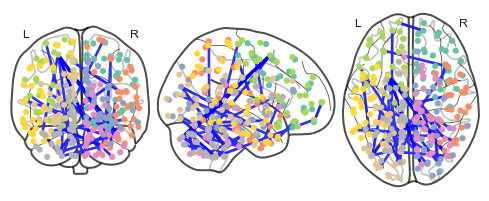

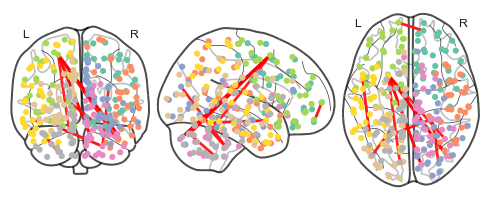

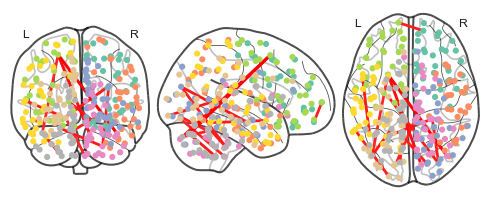

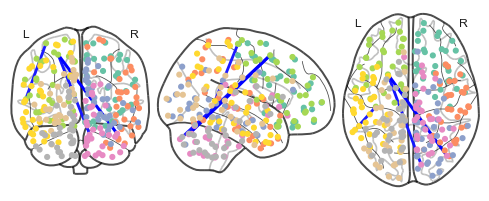

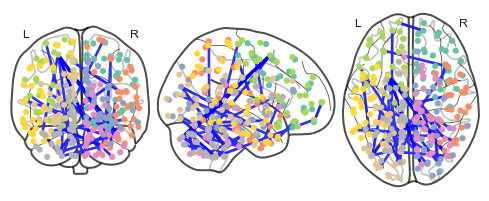

In [72]:
thresh = 5.
node_size = 17
print('start\t\t\t\t\t\t{0}'.format(datetime.datetime.now().strftime("%H:%M:%S")))
for key in keys:
    iq = key
    start = datetime.datetime.now()
    p, t, _ = permuted_ols(all_data[iq].values, 
                           all_data[conns].values, 
                           all_data[['{0}XSex'.format(iq), 
                                     '{0}XClass'.format(iq), 
                                     '{0}XClassXSex'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=10000)
    finish = datetime.datetime.now()
    elapsed = finish - start
    time = finish.strftime("%H:%M:%S")
    start = datetime.datetime.now()
    print('finished {0} OLS\t\t\t\t{1}\t\t{2} elapsed'.format(iq,time,elapsed))
    if np.max(p) >= 1.5:
        tmap = np.reshape(t, (268,268), order='F')
        pmap = np.reshape(p, (268,268), order='F')

        tdf = pd.DataFrame(tmap, columns=np.arange(1,269), index=np.arange(1,269))
        tdf.fillna(0, inplace=True)
        tdf.to_csv(join(sink_dir, '{0}_retr-phys_tval'.format(iq)))
        pdf = pd.DataFrame(pmap, columns=np.arange(1,269), index=np.arange(1,269))
        pdf.fillna(0, inplace=True)
        pdf.to_csv(join(sink_dir, '{0}_retr-phys_pval'.format(iq)))
        sig_edges = tdf[pdf >= 1.5]
        sig_edges.to_csv(join(sink_dir, '{0}_retr-phys_sig-edges'.format(iq)))

        q = plot_connectome(tmap, coordinates, edge_threshold=abs(thresh), node_size=node_size)
        q.savefig(join(fig_dir, '{0}_retr-phys_sig-edges'.format(iq)), dpi=300)
        finish = datetime.datetime.now()
        elapsed = finish - start
        time = finish.strftime("%H:%M:%S")
        start = datetime.datetime.now()
        print('saved {0} OLS outputs\t\t\t{1}\t\t{2} elapsed'.format(iq,time,elapsed))

    p, t, _ = permuted_ols(all_data['{0}XSex'.format(iq)].values, 
                           all_data[conns].values, 
                           all_data[['{0}'.format(iq), 
                                     '{0}XClass'.format(iq), 
                                     '{0}XClassXSex'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=10000)
    finish = datetime.datetime.now()
    elapsed = finish - start
    time = finish.strftime("%H:%M:%S")
    start = datetime.datetime.now()
    print('finished {0}XSex OLS\t\t{1}\t\t{2} elapsed'.format(iq,time,elapsed))

    if np.max(p) >= 1.5:
        tmap = np.reshape(t, (268,268), order='F')
        pmap = np.reshape(p, (268,268), order='F')


        tdf = pd.DataFrame(tmap, columns=np.arange(1,269), index=np.arange(1,269))
        tdf.fillna(0, inplace=True)
        tdf.to_csv(join(sink_dir, '{0}XSex_retr-phys_tval'.format(iq)))
        pdf = pd.DataFrame(pmap, columns=np.arange(1,269), index=np.arange(1,269))
        pdf.fillna(0, inplace=True)
        pdf.to_csv(join(sink_dir, '{0}XSex_retr-phys_pval'.format(iq)))
        sig_edges = tdf[pdf >= 1.5]
        sig_edges.to_csv(join(sink_dir, '{0}XSex_retr-phys_sig-edges'.format(iq)))

        q = plot_connectome(tmap, coordinates, edge_threshold=abs(thresh), node_size=node_size)
        q.savefig(join(fig_dir, '{0}XSex_retr-phys_sig-edges'.format(iq)), dpi=300)
        finish = datetime.datetime.now()
        elapsed = finish - start
        time = finish.strftime("%H:%M:%S")
        start = datetime.datetime.now()
        print('saved {0}XSex OLS outputs\t\t{1}\t\t{2} elapsed'.format(iq,time,elapsed))

    p, t, _ = permuted_ols(all_data['{0}XClass'.format(iq)].values, 
                           all_data[conns].values, 
                           all_data[['{0}'.format(iq), 
                                     '{0}XSex'.format(iq), 
                                     '{0}XClassXSex'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=10000)
    finish = datetime.datetime.now()
    elapsed = finish - start
    time = finish.strftime("%H:%M:%S")
    start = datetime.datetime.now()
    print('finished {0}XClass OLS\t\t{1}\t\t{2} elapsed'.format(iq,time,elapsed))
    if np.max(p) >= 1.5:
        tmap = np.reshape(t, (268,268), order='F')
        pmap = np.reshape(p, (268,268), order='F')

        tdf = pd.DataFrame(tmap, columns=np.arange(1,269), index=np.arange(1,269))
        tdf.fillna(0, inplace=True)
        tdf.to_csv(join(sink_dir, '{0}XClass_retr-phys_tval'.format(iq)))
        pdf = pd.DataFrame(pmap, columns=np.arange(1,269), index=np.arange(1,269))
        pdf.fillna(0, inplace=True)
        pdf.to_csv(join(sink_dir, '{0}XClass_retr-phys_pval'.format(iq)))
        sig_edges = tdf[pdf >= 1.5]
        sig_edges.to_csv(join(sink_dir, '{0}XClass_retr-phys_sig-edges'.format(iq)))

        q = plot_connectome(tmap, coordinates, edge_threshold=abs(thresh), node_size=node_size)
        q.savefig(join(fig_dir, '{0}XClass_retr-phys_sig-edges'.format(iq)), dpi=300)
        
        max_node1 = pdf.max(axis=0).idxmax()
        max_node2 = pdf.max(axis=1).idxmax()
        k = sns.lmplot(iq, avg_corrmat[max_node1][max_node2], data=all_data, palette=crayons_d, hue='F',
                       height=7, legend=False)
        k.savefig(join(fig_dir, 'rest-188sal-227dmn_VCI1XSex.png'.format(i, column)), dpi=300)
        
        finish = datetime.datetime.now()
        elapsed = finish - start
        time = finish.strftime("%H:%M:%S")
        start = datetime.datetime.now()
        print('saved {0}XClass OLS outputs\t{1}\t\t{2} elapsed'.format(iq,time,elapsed))


    p, t, _ = permuted_ols(all_data['{0}XClassXSex'.format(iq)].values, 
                           all_data[conns].values, 
                           all_data[['{0}'.format(iq), 
                                     '{0}XSex'.format(iq), 
                                     '{0}XClass'.format(iq),
                                     'F', 'Strt.Level', 'SexXClass', 
                                     'Age', 'Mod', 'post phys retr fd']].values,
                           n_perm=10000)
    finish = datetime.datetime.now()
    elapsed = finish - start
    time = finish.strftime("%H:%M:%S")
    start = datetime.datetime.now()
    print('finished {0}XClassXSex OLS\t\t{1}\t\t{2} elapsed'.format(iq,time,elapsed))
    if np.max(p) >= 1.5:
        tmap = np.reshape(t, (268,268), order='F')
        pmap = np.reshape(p, (268,268), order='F')

        tdf = pd.DataFrame(tmap, columns=np.arange(1,269), index=np.arange(1,269))
        tdf.fillna(0, inplace=True)
        tdf.to_csv(join(sink_dir, '{0}XClassXSex_retr-phys_tval'.format(iq)))
        pdf = pd.DataFrame(pmap, columns=np.arange(1,269), index=np.arange(1,269))
        pdf.fillna(0, inplace=True)
        pdf.to_csv(join(sink_dir, '{0}XClassXSex_retr-phys_pval'.format(iq)))
        sig_edges = tdf[pdf >= 1.5]
        sig_edges.to_csv(join(sink_dir, '{0}XClassXSex_retr-phys_sig-edges'.format(iq)))

        q = plot_connectome(tmap, coordinates, edge_threshold=abs(thresh), node_size=node_size)
        q.savefig(join(fig_dir, '{0}XClassXSex_retr-phys_sig-edges'.format(iq)), dpi=300)
        finish = datetime.datetime.now()
        elapsed = finish - start
        time = finish.strftime("%H:%M:%S")
        start = datetime.datetime.now()
        print('finished {0}XClassXSex OLS outputs\t{1}\t\t{2} elapsed'.format(iq,time,elapsed))

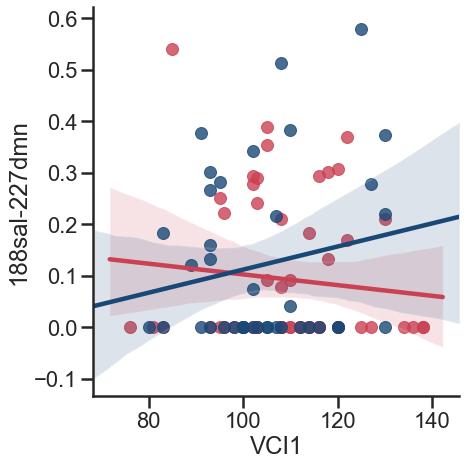

In [203]:
#fig,ax = plt.subplots()
all_data = pd.concat([big_df, rest_pre], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)
k = sns.lmplot('VCI1', '188sal-227dmn', data=all_data, palette=crayons_d, hue='F', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'rest-188sal-227dmn_VCI1XSex.png'.format(i, column)), dpi=300)

Significant connections:
174dmn 205dmn -4.510416165235839
205dmn 174dmn -4.510416165235839


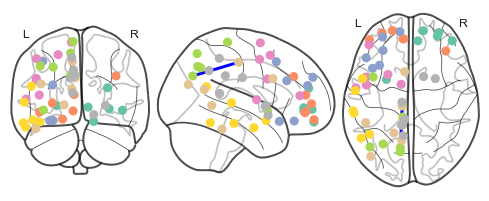

In [204]:
all_data = pd.concat([big_df, rest_post], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)
conns = list(set(rest_pre.columns))

for column in all_data[conns]:
    if all_data[column].std() < 0.05:
        all_data.drop(column, axis=1, inplace=True)
        conns = list(set(conns) - set([column]))

post_rest_sig = pd.DataFrame(index=conns)    
p, t, _ = permuted_ols(all_data['deltaVCIXSex'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['deltaVCIXClass'.format(iq), 'deltaVCI'.format(iq),
                                 'deltaVCIXClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'pre rest fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) > 1:
    post_rest_sig['deltaVCIXSex pre rest p'] = p.T
    post_rest_sig['deltaVCIXSex pre rest t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_prevci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_prevci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_prevci_rest_p.at[region1,region2] = post_rest_sig['deltaVCIXSex pre rest p']['{0}-{1}'.format(region1, region2)]
            sig_prevci_rest_t.at[region1,region2] = post_rest_sig['deltaVCIXSex pre rest t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_prevci_rest_p.index:
    if len(i) == 5:
        sig_prevci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_prevci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_prevci_rest_p.columns:
    if len(i) == 5:
        sig_prevci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_prevci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_prevci_rest_p.sort_index(inplace=True)
sig_prevci_rest_p.sort_index(axis=1,inplace=True)
sig_prevci_rest_t.sort_index(inplace=True)
sig_prevci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_prevci_rest_p.index:
    for j in sig_prevci_rest_p.columns:
        if sig_prevci_rest_p.at[i,j] >= 1:
            print(i,j, sig_prevci_rest_t.at[i,j])
            thresh = int(sig_prevci_rest_t.at[i,j])
sig_prevci_rest_p.fillna(0, inplace=True)
sig_prevci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_prevci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_prevci_rest_p.to_csv(join(sink_dir, 'rest-deltaVCIXSex_conn_pvals.csv'.format(task, iq)))
sig_prevci_rest_t.to_csv(join(sink_dir, 'rest-deltaVCIXSex_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'f-rest-deltaVCIXSex_conn_sig.png').format(task, iq), dpi=300)

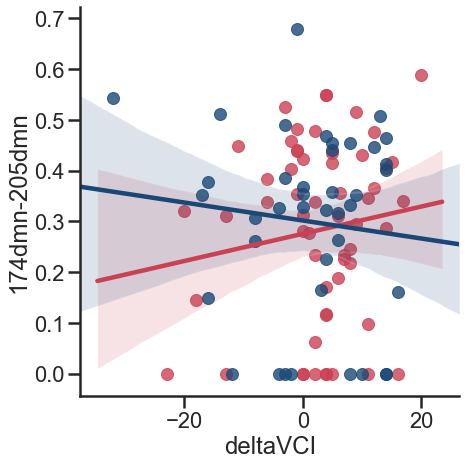

In [205]:
#fig,ax = plt.subplots()
all_data = pd.concat([big_df, rest_post], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)
k = sns.lmplot('deltaVCI', '174dmn-205dmn', data=all_data, palette=crayons_d, hue='F', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'rest-174dmn-205dmn_deltaVCIXSex.png'.format(i, column)), dpi=300)

In [206]:
significant.dropna(how='all')

rest       fci
pre  VCI  IQ        1.022285       NaN
          IQXSex    2.089384       NaN
     WMI  IQXSex         NaN  1.246272
post VCI  IQXSex    1.367551       NaN
     WMI  IQ             NaN  1.213683
          IQXSex         NaN  2.049644
          IQXClass       NaN  1.128319
     PRI  IQ             NaN  1.023109
     PSI  IQXSex         NaN  1.581376
     FSIQ IQ             NaN  1.172381
          IQXSex         NaN  1.487058

4.258665631512644
Significant connections:
011cen 177cen 4.258665631512644
177cen 011cen 4.258665631512644


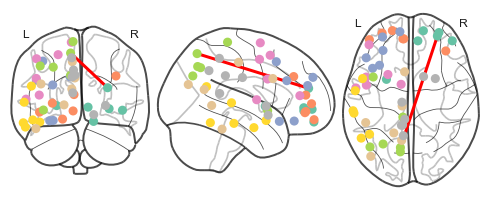

In [207]:
all_data = pd.concat([big_df, fci_shen_pre_phys], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)
conns = list(set(fci_shen_pre_phys.columns))

for column in all_data[conns]:
    if all_data[column].std() < 0.05:
        all_data.drop(column, axis=1, inplace=True)
        conns = list(set(conns) - set([column]))

post_rest_sig = pd.DataFrame(index=conns)    
p, t, _ = permuted_ols(all_data['WMI1XSex'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['WMI1XClass'.format(iq), 'WMI1'.format(iq),
                                 'WMI1XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'pre phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['WMI1XSex pre phys fci p'] = p.T
    post_rest_sig['WMI1XSex pre phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_prevci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_prevci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_prevci_rest_p.at[region1,region2] = post_rest_sig['WMI1XSex pre phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_prevci_rest_t.at[region1,region2] = post_rest_sig['WMI1XSex pre phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_prevci_rest_p.index:
    if len(i) == 5:
        sig_prevci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_prevci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_prevci_rest_p.columns:
    if len(i) == 5:
        sig_prevci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_prevci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_prevci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_prevci_rest_p.sort_index(inplace=True)
sig_prevci_rest_p.sort_index(axis=1,inplace=True)
sig_prevci_rest_t.sort_index(inplace=True)
sig_prevci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_prevci_rest_p.index:
    for j in sig_prevci_rest_p.columns:
        if sig_prevci_rest_p.at[i,j] >= 1:
            print(i,j, sig_prevci_rest_t.at[i,j])
            thresh = int(sig_prevci_rest_t.at[i,j])
sig_prevci_rest_p.fillna(0, inplace=True)
sig_prevci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_prevci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_prevci_rest_p.to_csv(join(sink_dir, 'fci-WMI1XSex_conn_pvals.csv'.format(task, iq)))
sig_prevci_rest_t.to_csv(join(sink_dir, 'fci-WMI1XSex_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-WMI1XSex_conn_sig.png').format(task, iq), dpi=300)

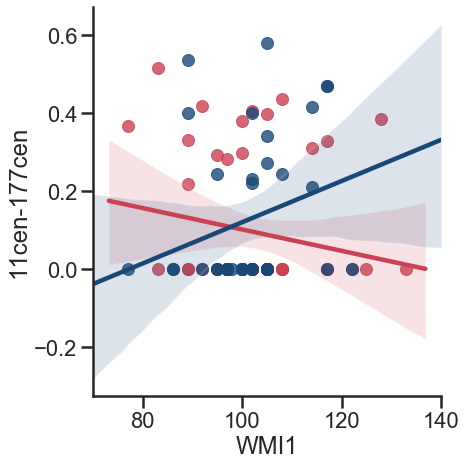

In [208]:
all_data = pd.concat([big_df, fci_shen_pre_phys], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)

k = sns.lmplot('WMI1', '11cen-177cen', data=all_data, palette=crayons_d, hue='F', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'fci-11cen-177cen_WMI1XSex.png'.format(i, column)), dpi=300)

4.198453366916679
Significant connections:
138dmn 200cen 4.198453366916679
200cen 138dmn 4.198453366916679


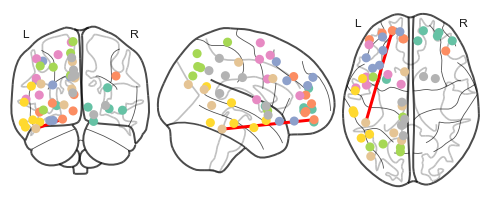

In [161]:
all_data = pd.concat([big_df, fci_shen_post_phys], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)
conns = list(set(fci_shen_post_phys.columns))

for column in all_data[conns]:
    if all_data[column].std() < 0.05:
        all_data.drop(column, axis=1, inplace=True)
        conns = list(set(conns) - set([column]))

post_rest_sig = pd.DataFrame(index=conns)    
p, t, _ = permuted_ols(all_data['WMI2'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['WMI2XClass'.format(iq), 'WMI2XSex'.format(iq),
                                 'WMI2XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['WMI2 post phys fci p'] = p.T
    post_rest_sig['WMI2 post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['WMI2 post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['WMI2 post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-WMI2_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-WMI2_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-WMI2_conn_sig.png').format(task, iq), dpi=300)

4.764546610545469
Significant connections:
178dmn 223dmn 4.764546610545469
223dmn 178dmn 4.764546610545469


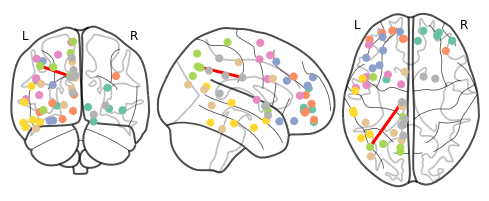

In [123]:
p, t, _ = permuted_ols(all_data['WMI2XSex'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['WMI2XClass'.format(iq), 'WMI2'.format(iq),
                                 'WMI2XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['WMI2XSex post phys fci p'] = p.T
    post_rest_sig['WMI2XSex post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['WMI2XSex post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['WMI2XSex post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-WMI2XSex_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-WMI2XSex_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-WMI2XSex_conn_sig.png').format(task, iq), dpi=300)

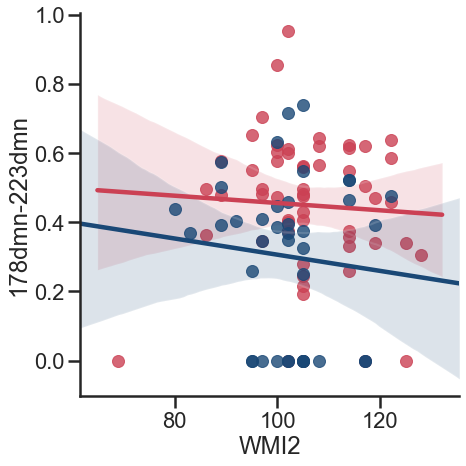

In [162]:
all_data = pd.concat([big_df, fci_shen_post_phys], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)

k = sns.lmplot('WMI2', '178dmn-223dmn', data=all_data, palette=crayons_d, hue='F', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'fci-178dmn-223dmn_WMI2XSex.png'.format(i, column)), dpi=300)

3.955683810502702
Significant connections:
138dmn 200cen -4.151833728500401
200cen 138dmn -4.151833728500401


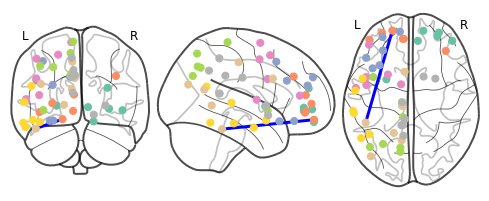

In [125]:
p, t, _ = permuted_ols(all_data['WMI2XClass'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['WMI2XSex'.format(iq), 'WMI2'.format(iq),
                                 'WMI2XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['WMI2XClass post phys fci p'] = p.T
    post_rest_sig['WMI2XClass post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['WMI2XClass post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['WMI2XClass post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-WMI2XClass_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-WMI2XClass_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-WMI2XClass_conn_sig.png').format(task, iq), dpi=300)

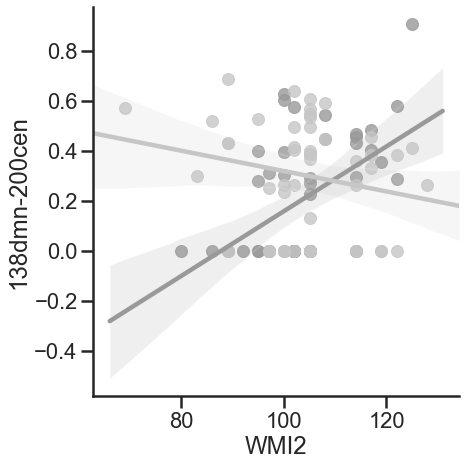

In [164]:
all_data = pd.concat([big_df, fci_shen_post_phys], axis=1)
all_data.dropna(how='any', axis=0, inplace=True)

k = sns.lmplot('WMI2', '138dmn-200cen', data=all_data, palette=grays, hue='Mod', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'fci-178dmn-200cen_WMI2XClass.png'.format(i, column)), dpi=300)

2.174150404599952
Significant connections:
223dmn 224dmn -4.489151477069809
224dmn 223dmn -4.489151477069809


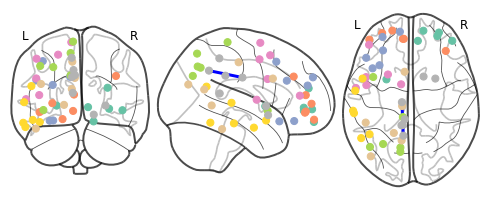

In [127]:
p, t, _ = permuted_ols(all_data['PSI2XSex'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['PSI2XClass'.format(iq), 'PSI2'.format(iq),
                                 'PSI2XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['PSI2XSex post phys fci p'] = p.T
    post_rest_sig['PSI2XSex post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['PSI2XSex post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['PSI2XSex post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-PSI2XSex_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-PSI2XSex_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-PSI2XSex_conn_sig.png').format(task, iq), dpi=300)

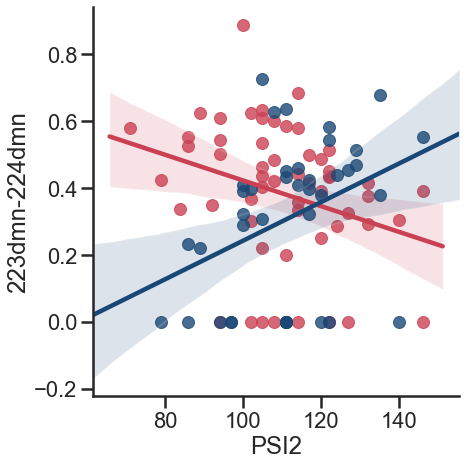

In [166]:
#all_data = pd.concat([big_df, fci_shen_post_phys], axis=1)
#all_data.dropna(how='any', axis=0, inplace=True)

k = sns.lmplot('PSI2', '223dmn-224dmn', data=all_data, palette=crayons_d, hue='F', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'fci-223dmn-224dmn_PSI2XSex.png'.format(i, column)), dpi=300)

4.078345923525434
Significant connections:
143cen 226dmn 4.078345923525434
226dmn 143cen 4.078345923525434


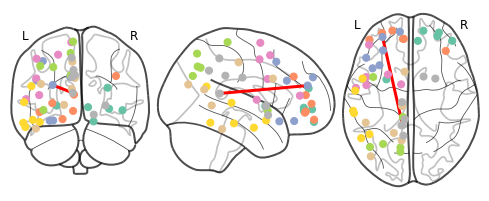

In [128]:
post_rest_sig = pd.DataFrame(index=conns)    
p, t, _ = permuted_ols(all_data['PRI2'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['PRI2XClass'.format(iq), 'PRI2XSex'.format(iq),
                                 'PRI2XClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['PRI2 post phys fci p'] = p.T
    post_rest_sig['PRI2 post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['PRI2 post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['PRI2 post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-PRI2_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-PRI2_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-PRI2_conn_sig.png').format(task, iq), dpi=300)

2.920868413221816
Significant connections:
147cen 224dmn -4.186040556978
224dmn 147cen -4.186040556978


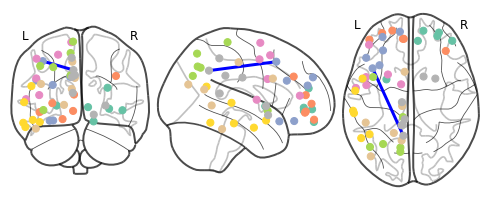

In [129]:
post_rest_sig = pd.DataFrame(index=conns)    
p, t, _ = permuted_ols(all_data['deltaFSIQ'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['deltaFSIQXClass'.format(iq), 'deltaFSIQXSex'.format(iq),
                                 'deltaFSIQXClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['deltaFSIQ post phys fci p'] = p.T
    post_rest_sig['deltaFSIQ post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['deltaFSIQ post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['deltaFSIQ post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-deltaFSIQ_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-deltaFSIQ_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-deltaFSIQ_conn_sig.png').format(task, iq), dpi=300)

4.3911971858303716
Significant connections:
147cen 224dmn 4.3911971858303716
224dmn 147cen 4.3911971858303716


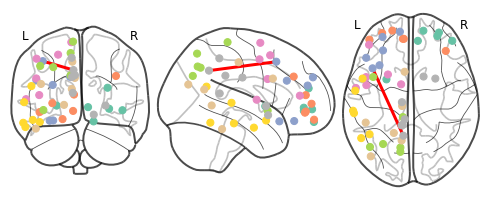

In [130]:
p, t, _ = permuted_ols(all_data['deltaFSIQXSex'.format(iq)].values, 
                       all_data[conns].values,
                       all_data[['deltaFSIQXClass'.format(iq), 'deltaFSIQ'.format(iq),
                                 'deltaFSIQXClassXSex'.format(iq),
                                 'F', 'Strt.Level', 'SexXClass',
                                 'Age', 'Mod', 'post phys fci fd'.format(key)]].values,
                       n_perm=10000)

if np.max(p) >= 1:
    print(np.max(t))
    post_rest_sig['deltaFSIQXSex post phys fci p'] = p.T
    post_rest_sig['deltaFSIQXSex post phys fci t'] = t.T

index = []
for column in post_rest_sig.index:
    index.append(column.split('-')[0])
regions = list(set(index))
sig_postvci_rest_p = pd.DataFrame(index=regions, columns=regions)
sig_postvci_rest_t = pd.DataFrame(index=regions, columns=regions)
for region1 in regions:
    for region2 in regions:
        try:
            sig_postvci_rest_p.at[region1,region2] = post_rest_sig['deltaFSIQXSex post phys fci p']['{0}-{1}'.format(region1, region2)]
            sig_postvci_rest_t.at[region1,region2] = post_rest_sig['deltaFSIQXSex post phys fci t']['{0}-{1}'.format(region1, region2)]
        except Exception as e:
            pass
for i in sig_postvci_rest_p.index:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, inplace=True)
for i in sig_postvci_rest_p.columns:
    if len(i) == 5:
        sig_postvci_rest_t.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '0{0}'.format(i)}, axis=1, inplace=True)
    if len(i) == 4:
        sig_postvci_rest_t.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
        sig_postvci_rest_p.rename({'{0}'.format(i): '00{0}'.format(i)}, axis=1, inplace=True)
sig_postvci_rest_p.sort_index(inplace=True)
sig_postvci_rest_p.sort_index(axis=1,inplace=True)
sig_postvci_rest_t.sort_index(inplace=True)
sig_postvci_rest_t.sort_index(axis=1,inplace=True)
print('Significant connections:')
for i in sig_postvci_rest_p.index:
    for j in sig_postvci_rest_p.columns:
        if sig_postvci_rest_p.at[i,j] >= 1:
            print(i,j, sig_postvci_rest_t.at[i,j])
            thresh = int(sig_postvci_rest_t.at[i,j])
sig_postvci_rest_p.fillna(0, inplace=True)
sig_postvci_rest_t.fillna(0, inplace=True)
q = plot_connectome(sig_postvci_rest_t.values, coordinates, edge_threshold=abs(thresh))
sig_postvci_rest_p.to_csv(join(sink_dir, 'fci-deltaFSIQXSex_conn_pvals.csv'.format(task, iq)))
sig_postvci_rest_t.to_csv(join(sink_dir, 'fci-deltaFSIQXSex_conn-tvals.csv'.format(task, iq)))
q.savefig(join(fig_dir, 'fci-deltaFSIQXSex_conn_sig.png').format(task, iq), dpi=300)

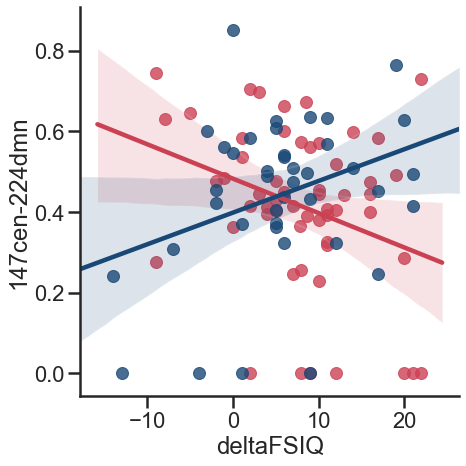

In [168]:
#all_data = pd.concat([big_df, fci_shen_post_phys], axis=1)
#all_data.dropna(how='any', axis=0, inplace=True)

k = sns.lmplot('deltaFSIQ', '147cen-224dmn', data=all_data, palette=crayons_d, hue='F', 
               height=7, legend=False)
k.savefig(join(fig_dir, 'fci-147cen-224dmn_deltaFSIQXSex.png'.format(i, column)), dpi=300)